#**News Tool**

Hi! Welcome to the news tool, set your query terms and parameters below (choose keywords and set parameters) and run the whole notebook, the go to the dashboard section for plots and resulting dataframe will all the articles collected.

##First steps.

Import Packages.

In [ ]:
import nltk
nltk.download('punkt')  
nltk.download('averaged_perceptron_tagger')  
nltk.download('maxent_ne_chunker') 
nltk.download('words')  
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
nltk.download('omw-1.4')
from textblob import TextBlob
from dateutil import parser
import requests as r
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import date
from datetime import datetime
import spacy

Choose keywords and set parameters

In [26]:
guardian_api_key = '231ce917-65b5-4019-b365-c79f213379d1'
query_keywords = '"Rio Tinto"' #Delete double quotes if not an exact phrase query (free text)
query_fields = 'headline' #Other popular option body
from_date = '2000-01-01' #'yyyy,MM,dd'
to_date= '2022-12-31' #'yyyy,MM,dd'
page= '1' # Page number to extract articles from, can only do one page at a time
page_size = '100' # up to 200
prod_off = 'aus' #only news from the australia edition
order_by = 'newest' # relevance also available.

## Processing Data.

Call API and generate response with articles

In [27]:
response = r.get(f'https://content.guardianapis.com/search?q={query_keywords}&query-fields={query_fields}&from-date={from_date}&to-date={to_date}&page={page}&page-size={page_size}&production-office={prod_off}&order-by={order_by}&api-key={guardian_api_key}')
art_response = response.json()

In [28]:
art_response

{'response': {'status': 'ok',
  'userTier': 'developer',
  'total': 81,
  'startIndex': 1,
  'pageSize': 100,
  'currentPage': 1,
  'pages': 1,
  'orderBy': 'newest',
  'results': [{'id': 'business/2022/oct/03/rio-tinto-calls-for-board-resignation-over-kakadu-uranium-site-clean-up',
    'type': 'article',
    'sectionId': 'business',
    'sectionName': 'Business',
    'webPublicationDate': '2022-10-03T00:51:31Z',
    'webTitle': 'Directors of firm responsible for clean-up at Kakadu uranium site will resign amid fight with Rio Tinto',
    'webUrl': 'https://www.theguardian.com/business/2022/oct/03/rio-tinto-calls-for-board-resignation-over-kakadu-uranium-site-clean-up',
    'apiUrl': 'https://content.guardianapis.com/business/2022/oct/03/rio-tinto-calls-for-board-resignation-over-kakadu-uranium-site-clean-up',
    'isHosted': False,
    'pillarId': 'pillar/news',
    'pillarName': 'News'},
   {'id': 'business/2022/sep/13/russian-aluminium-giant-cut-out-of-queensland-operation-to-abide-b

In [30]:
# Creating a loop to extract article headline.
art_title = []
for article in art_response["response"]["results"]:
    extract_title= article['webTitle']
    art_title.append(extract_title)

# Creating a loop to extract article content.
art_body = []
for article in art_response["response"]["results"]:
    url= (f'{article["apiUrl"]}?api-key={guardian_api_key}&show-fields=bodyText')
    article_content= r.get(url).json()
    body_text= article_content["response"]['content']['fields']['bodyText']
    art_body.append(body_text)

# Creating a loop to extract article date.
art_dates = []
for article in art_response["response"]["results"]:
    extract_dates= article['webPublicationDate']
    extract_dates = parser.parse(extract_dates)
    extract_dates = extract_dates.date()
    art_dates.append(extract_dates)

# Creating a loop to extract article section.
art_section = []
for article in art_response["response"]["results"]:
    extract_sect= article['sectionName']
    art_section.append(extract_sect)

# Creating a loop to extract url.
art_url = []
for article in art_response["response"]["results"]:
    extract_url= article['webUrl']
    art_url.append(extract_url)


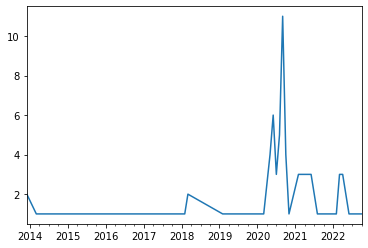

In [32]:
art_body_date = pd.DataFrame(
    {'date': art_dates,
     'headline': art_title,
     'article': art_body,
     'section': art_section,
     'url': art_url
     })

art_body_date['year_month'] = pd.to_datetime(art_body_date['date']).dt.to_period('M')

plot_overtime = art_body_date['year_month'].value_counts().sort_index().plot(kind='line')

Creating a loop to extract Named entities recognized.

In [36]:
art_body_date['chunks'] = art_body_date.article.apply(lambda x: nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(x))))
art_ent = []
for i, v in art_body_date['chunks'].iteritems():
  temp_list = []
  for chunk in v:
    if hasattr(chunk,'label'):
      temp_list.append(str(chunk))
  art_ent.append(temp_list)



In [124]:
art_body_date_ent = pd.DataFrame(
    {'date': art_dates,
     'headline': art_title,
     'article': art_body,
     'section': art_section,
     'url': art_url,
     'entities': art_ent
     })


Pre-processing

In [125]:
art_clean = art_body_date_ent


In [ ]:

art_clean['article'] = art_clean['article'].astype(str).str.lower()
art_clean['article'] = art_clean['article'].str.replace(r'[^\w\s]+', '')
art_clean['article'] = art_clean['article'].str.replace('\d+', '')
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer('\w+')
art_clean['text_token']=art_clean['article'].apply(regexp.tokenize)
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words("english")
newStopWords = ['rio','tinto','said','would','mining','company']
stopwords.extend(newStopWords)
art_clean['text_token'] = art_clean['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
art_clean['text_string'] = art_clean['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))






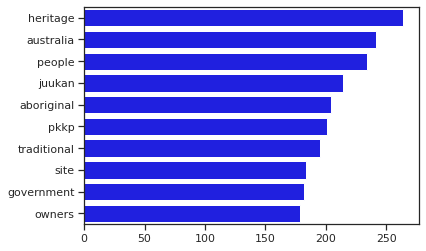

In [130]:
all_words = ' '.join([word for word in art_clean['text_string']])
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

words = nltk.word_tokenize(all_words)
fd = FreqDist(words)
top_10 = fd.most_common(10)
fdist = pd.Series(dict(top_10))
import seaborn as sns
sns.set_theme(style="ticks")

sns.barplot(y=fdist.index, x=fdist.values, color='blue')

Sentiment Analysis

In [44]:
analyzer = SentimentIntensityAnalyzer()

art_body_date_ent['polarity'] = art_body_date_ent['headline'].apply(lambda x: analyzer.polarity_scores(x))


In [45]:
# Change data structure
art_body_date_ent = pd.concat(
    [art_body_date_ent.drop(['polarity'], axis=1),
     art_body_date_ent['polarity'].apply(pd.Series)], axis=1)

# Create new variable with sentiment "neutral," "positive" and "negative"
art_body_date_ent['sentiment'] = art_body_date_ent['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

#DASHBOARD

*Results*

In [63]:
print(f'your query for news articles from {query_keywords} in the production office {prod_off} threw {arts} results')

your query for news articles from "Rio Tinto" in the production office aus threw 81 results


Articles Over time.

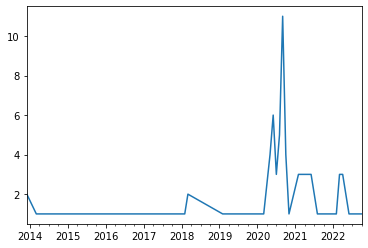

In [67]:
plot_overtime = art_body_date['year_month'].value_counts().sort_index().plot(kind='line')

Sentiment by Article

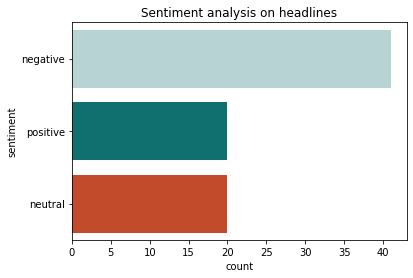

In [65]:
arts = art_response["response"]['total']

test2 = sns.countplot(y='sentiment',
             data=art_body_date_ent,
              palette=['#b2d8d8',"#008080", '#db3d13']
             ).set(title='Sentiment analysis on headlines')


Sentiment over time

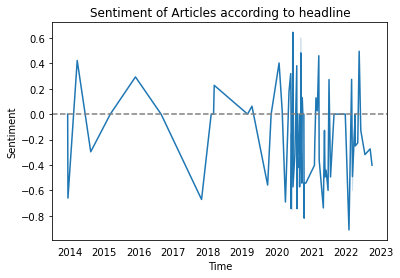

In [69]:
g = sns.lineplot(x='date', y='compound', data=art_body_date_ent)

g.set(title='Sentiment of Articles according to headline')
g.set(xlabel="Time")
g.set(ylabel="Sentiment")
g.tick_params(bottom=False)

g.axhline(0, ls='--', c = 'grey')

Sentiment Boxplot (Distribution)

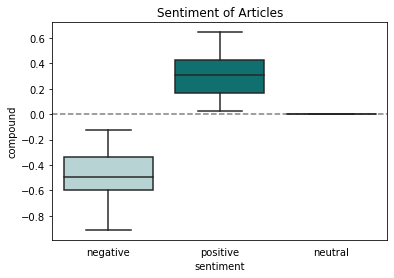

In [52]:
g = sns.lineplot(x='date', y='compound', data=art_body_date_ent)
g.set(xticklabels=[])
g.set(title='Sentiment of Articles')
g.set(xlabel="Time")
g.set(ylabel="Sentiment")
g.tick_params(bottom=False)
g.axhline(0, ls='--', c = 'grey')

test1 = sns.boxplot(y='compound',
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'],
            data=art_body_date_ent)

In [ ]:
Most common words

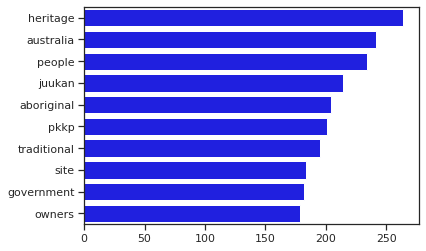

In [131]:
sns.barplot(y=fdist.index, x=fdist.values, color='blue')

Articles Dataframe (Explore)

In [70]:
art_body_date_ent

,date,headline,article,section,url,entities,neg,neu,pos,compound,sentiment
0,2022-10-03,Directors of firm responsible for clean-up at ...,The directors of the company that owns the Jab...,Business,https://www.theguardian.com/business/2022/oct/...,"[(ORGANIZATION Jabiluka/NNP), (PERSON Ranger/N...",0.235,0.657,0.108,-0.4019,negative
1,2022-09-13,Russian aluminium giant cut out of Queensland ...,Rio Tinto says it would have breached sanction...,Business,https://www.theguardian.com/business/2022/sep/...,"[(PERSON Rio/NNP), (ORGANIZATION Tinto/NNP), (...",0.130,0.870,0.000,-0.2732,negative
2,2022-07-20,Rio Tinto agrees to pay additional $613m to se...,Rio Tinto has agreed to pay the Australian tax...,Australia news,https://www.theguardian.com/australia-news/202...,"[(PERSON Rio/NNP), (ORGANIZATION Tinto/NNP), (...",0.243,0.651,0.107,-0.3182,negative
3,2022-06-06,Subsidiary of Russian company sues Rio Tinto f...,A subsidiary of Russian aluminium giant Rusal ...,Business,https://www.theguardian.com/business/2022/jun/...,"[(GPE Russian/JJ), (GSP Rusal/NNP), (PERSON Ri...",0.097,0.903,0.000,-0.1280,negative
4,2022-05-20,Juukan Gorge traditional owners sign agreement...,The traditional owners of Juukan Gorge have si...,Australia news,https://www.theguardian.com/australia-news/202...,"[(PERSON Juukan/NNP Gorge/NNP), (PERSON Rio/NN...",0.000,0.802,0.198,0.4939,positive
...,...,...,...,...,...,...,...,...,...,...,...
76,2015-03-06,NSW government suggests entire village be relo...,The relocation of the entire village of Bulga ...,Environment,https://www.theguardian.com/environment/2015/m...,"[(GPE Bulga/NNP), (GPE New/NNP South/NNP Wales...",0.000,1.000,0.000,0.0000,neutral
77,2014-08-11,Boom and dust: uncertain future for the mining...,"Dixon Peters, a 28-year-old Yolngu man from th...",World news,https://www.theguardian.com/world/2014/aug/11/...,"[(PERSON Dixon/NNP), (ORGANIZATION Peters/NNP)...",0.155,0.845,0.000,-0.2960,negative
78,2014-03-21,Rio Tinto chief urges carbon capture progress ...,A Rio Tinto executive has claimed it is “fruit...,Business,https://www.theguardian.com/business/2014/mar/...,"[(GPE Australian/JJ), (ORGANIZATION Energy/NNP...",0.000,0.781,0.219,0.4215,positive
79,2013-12-13,Rio Tinto and NSW deny abusing planning proces...,Mining giant Rio Tinto and the NSW government ...,World news,https://www.theguardian.com/world/2013/dec/13/...,"[(ORGANIZATION Rio/NNP Tinto/NNP), (ORGANIZATI...",0.351,0.649,0.000,-0.6597,negative
